In [1]:
import numpy as np
import pickle
import pandas as pd
from warnings import catch_warnings
from warnings import simplefilter
from IPython.display import display
from matplotlib import pyplot as plt
plt.style.use("seaborn-darkgrid")
import warnings
warnings.filterwarnings("ignore")
from GP_surrogate_model_2 import *
from Inverse_Uncertainty_Quantification import *

# Gaussian Process Regression surogate model 

In [2]:
## The ground-truth data

strain_fe_media = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35]
stress_fe_media = [0, 0.00169707, 0.00336693, 0.00501758, 0.00665913, 0.00830489, 0.00997227, 0.0116837, 0.0134675, 0.0153589, 0.0174013, 0.0196476, 0.0221622, 0.0250236, 0.028327, 0.0321884, 0.0367485, 0.0421783, 0.0486846, 0.0565163, 0.0659717, 0.0774054, 0.0912357, 0.107951, 0.128119, 0.152385, 0.181485, 0.216236, 0.257543, 0.306386, 0.363809, 0.430904, 0.508782, 0.598541, 0.701216, 0.817721]
  
stress_fe_media  = np.array(stress_fe_media)[list(np.arange(0, len(stress_fe_media), 2))]
strain_fe_media  = np.array(strain_fe_media)[list(np.arange(0, len(strain_fe_media), 2))]

initial_coeffs_media = [0.3,0,0,0,0,1050]

coefficients_media = pd.read_csv(r'data/strain_values_media_18.csv').to_numpy()
stress_media = pd.read_csv(r'data/stress_values_media_18.csv').to_numpy()



In [4]:
'''
Split the data into training and testing sets;
X_train/X_test contarins
'''
X_train, y_train, X_test, y_test = train_test_data(coefficients_sets = coefficients_media, 
                                                   stress_values = stress_media, 
                                                   strain_values = strain_fe_media, 
                                                   ratio = 0.8)

model = gp_regression_model(X_train, y_train)

In [9]:
'''
Test in unknown data points and calculate root mean squared error (RMSE)
'''
simY, simMse = model.predict(X_test)  # Mean and variance of prediction
rmse = np.sqrt(mse(y_test, simY))  # Root mean squared error

print("RMSE: {}".format(rmse))

RMSE: 0.016931549446818166


In [3]:
## Import the pretrained Gaussian process regression surogate model for prediction of stress values.

with open('data/GPy_model_media_18.pkl', 'rb') as file:
    model = pickle.load(file)

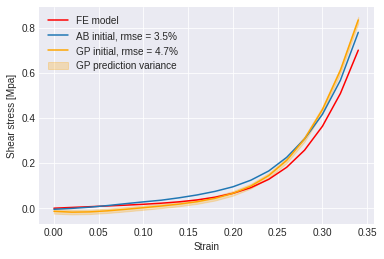

In [5]:
'''
Comparision of GP prediction and AB model response with initial coefficient guess with ground truth data
'''

AB_initial_response = [-0.00484737,-0.00084348,0.00454305,0.0116706,0.0200137,0.0280109,0.0355181,0.0461782,0.0588343,0.07464,0.0949704,0.124247,0.165261,0.225507,0.307474,0.416782,0.567361,0.780216]
  
visualise_gp_comparision(gp_model = model, coefficient_set = initial_coeffs_media,
                            strain_values = strain_fe_media, real_stress_values = stress_fe_media,
                               AB_initial = AB_initial_response)  

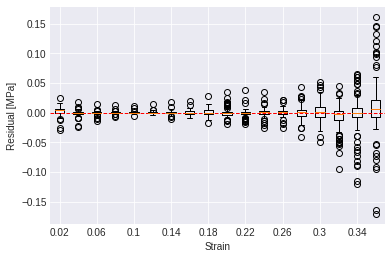

In [31]:
'''
Visualise difference between true stres values and simulated GP stress prediction per strain values 
'''
visualise_resiudal(strain_fe_media, X_test, y_test, simY)

# Bayesian Calibration

In [5]:
'''
Performing Bayesian Calibration for Media layer
'''                     
                                             
## Define loglikelihood
loglike = Loglike(stress_fe_media, strain_fe_media)

## Lower and upper bounds of prior distributions
media_lower_bounds = [0,0,0,0,0,800]
media_upper_bounds = [3,3,3,3,3,1200]
uncertainty = 0.6
                      
## Perform first step of bayesian calibration, where posterior distribution 
## is sampled from the initial prior distribution and likelohood
trace_0 = initial_inference(likelihood = loglike, lower_bounds = media_lower_bounds, 
                        upper_bounds = media_upper_bounds, 
                        sigma = uncertainty)
  
## Perform N iterations of bayesian calibration
bayesian_calibration(initial_trace=trace_0, N_iterations=60, loglike=loglike)

In [4]:
traces_media = []
for i in range(60):
    with open('data/traces_media/trace_18_%s.pkl'%i, 'rb') as buff:
        traces_media.append(pickle.load(buff))

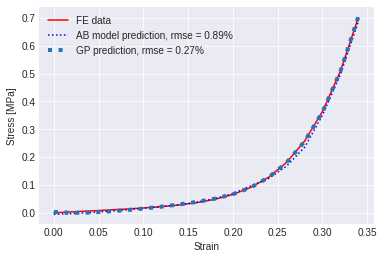

In [6]:
'''
Test in experimental data 
'''
AB_media_calibrated = [-0.00573361,-0.00269623,0.000366507,0.00547262,0.0103093,0.0161147,0.0224274,0.0288139,0.0384203,0.0515264,0.0686126,0.0963543,0.123549,0.16821,0.235032,0.35073,0.49698,0.686511]

visualise_calibration_comparision(model, traces = traces_media, AB_calibrated = AB_media_calibrated, 
                                  strain_values = strain_fe_media, real_stress_values = stress_fe_media)

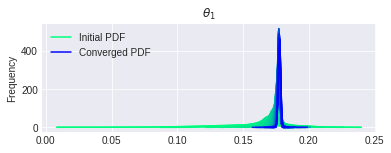

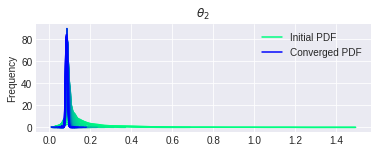

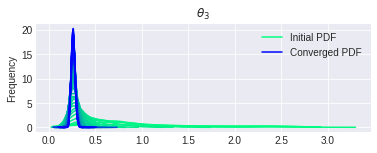

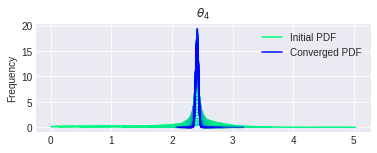

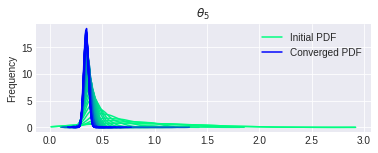

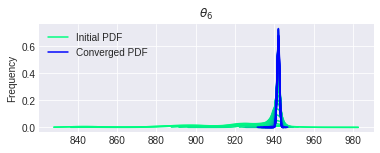

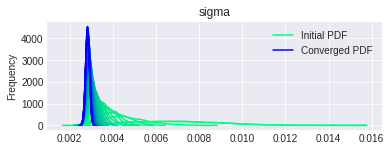

In [5]:
visualise_pdf_1D(traces_media)